# PH554 mid-semester exam



- Name: Siddhant Midha
- Roll no.: 200070078
- *Declaration*. I have adhered to the academic code of conduct and will do so in the future as well.



For each of the following problems, ~30-40% of the assigned marks will be reserved for evaluating the presentation of your work, e.g. tables and plots, annotation inside the coding blocks, markdown segments to describe your work, etc. Be explicit about all the relevant steps. And of course, your codes should run without bugs!

Remember to include a code of conduct preamble in your submission.

#### All the best!

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from qutip import *
from scipy.sparse import csr_matrix
from numpy import sqrt, pi 
plt.rcParams.update({'font.size': 25 })
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



In [2]:
np.random.seed(124)

## Problem 1: (5 marks)

Compare the convergence of the Power method and the Lanczos method for the Heisenberg chain for several different sizes. Define a criterion for convergence with which you can compare the two methods. Comment on your results.

In [74]:
# Standard dictionary, flipping, Hamiltonian functions taken from the tutorials

def create_statedict(L):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    states_dict = {}
    for i in range((D)):
        state = bin(i)[2:]
        state = '0'*(L-len(state)) + state 
        states_dict[i] = state 
    return states_dict
def sum_str(str):
    s = np.sum([2*int(bit)-1 for bit in list(str)])
    return s

def flipbits(state,i,j):
    copystate = state 
    copystate = list(copystate)
    bit_i = state[i]
    bit_j = state[j]
    if bit_i == '0':
        copystate[i] = '1'
    else:
        copystate[i] = '0'
    if bit_j == '0':
        copystate[j] = '1'
    else:
        copystate[j] = '0'
    copystate = ''.join(copystate)
    return copystate

def heisen_hamil(L,J,state_dict,BC='closed'):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    H = np.zeros((D,D))
    sites = L-2 if BC == 'open' else L-1
    for site in range(sites):
        #loop over i = 0,1,...,L-2 as there are total L-1 2-local terms in OBC
        for i in range(D):
                state = state_dict[i]
                #diagonal part
                s_site = 2 * int(state[site]) - 1
                s_nextsite = 2 * int(state[(site+1)%L]) - 1 
                H[i,i] += s_site * s_nextsite * 1/4
                #off-diagonal part
                if state[site] != state[(site+1)%L]:
                    nextstate = flipbits(state,site,(site+1)%L)
                    # print(site, state, nextstate)
                    j  = int(nextstate,2)
                    H[i,j] += 1/2
    return H * J


In [75]:
def actH(state):
    #state is a 2 ** L dim vector
    H_sp = csr_matrix(H)
    return H_sp.dot(state)

def inner_pdt(state1,state2):
    return np.sum(np.conjugate(state1) * state2) 
    
def add_dim(mat):
    n, n = np.shape(mat)
    mat_ = np.zeros((n+1,n+1))
    mat_[:n,:n] = mat
    return mat_

def power_method(H, ITER=100,conv_check_state = False):
    '''function for the power method with an additional feature of returning a array displaying the convergence rate'''
    '''if conv_check_state = True, then the arr will be returned, else, the G.S. eigenket returned by the method'''
    arr = []
    D, D = np.shape(H)
    start_state = np.random.normal(size=D)
    for i in tqdm(range(ITER)):
        state = actH(start_state)
        state = state/np.linalg.norm(state)
        if conv_check_state and i > 10:
            arr.append(np.linalg.norm(start_state + state))
        start_state = state 
    if conv_check_state:
        return arr
    return start_state

def lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=False,reortho=False):
    '''function for the Lanczos method with multiple additional features'''
    '''if conv_check_show = True, then FOUR arrays consisting of the four lowest energies as a function of the iteration are returned for analysis'''
    '''if conv_check_eig = True, then a metric for convergence as a function of the iteration is returned'''
    '''if none of the above two are true, then a set of eigenvectors and eigenvalues are returned which can directly be used in place of np.linalg.eig for large matrices'''
    '''if reortho = True, then dynamic reorthogonalization is applied, else not'''
    arr1 = []
    arr2 = []
    arr3 = []
    arr4 = []
    arr = []

    M = H.shape[0]
    lancvec_mat = np.zeros((M,ITER+1))
    diag = np.zeros(ITER)
    offdiag = np.zeros(ITER)

    lancvec_mat[:,0] = np.random.normal(size = M)
    lancvec_mat[:,0] /= sqrt(inner_pdt(lancvec_mat[:,0],lancvec_mat[:,0]))

    for jj in tqdm(range(ITER)):
        lancvec_mat[:,jj+1] = actH(lancvec_mat[:,jj])
        diag[jj] = inner_pdt(lancvec_mat[:,jj],lancvec_mat[:,jj+1])
        lancvec_mat[:,jj+1] -= diag[jj] * (lancvec_mat[:,jj])
        if jj != 0:
            lancvec_mat[:,jj+1] -= offdiag[jj-1] * lancvec_mat[:,jj-1]
        offdiag[jj] = sqrt(inner_pdt(lancvec_mat[:,jj+1],lancvec_mat[:,jj+1]))
        lancvec_mat[:,jj+1] /= offdiag[jj]

        if jj >= 3 and reortho == True:  
            for j in range(0,jj):
                norm = inner_pdt(lancvec_mat[:,jj+1], lancvec_mat[:,j])
                tempvec = lancvec_mat[:,jj+1] - norm * lancvec_mat[:,j]
                lancvec_mat[:,jj+1] = tempvec / sqrt(inner_pdt(tempvec,tempvec))

        if jj >= 4 and conv_check_eig == True:
            H_lanc_temp = np.diag(diag[:jj-1]) + np.diag(offdiag[:jj-2], 1) + np.diag(offdiag[:jj-2], -1)
            v, _ = np.linalg.eigh(H_lanc_temp)
            sorted_indices = np.argsort(v)
            sorted_eigenvalues = v[sorted_indices]
            gs_eig_old = sorted_eigenvalues[0]
            H_lanc_temp = np.diag(diag[:jj]) + np.diag(offdiag[:jj-1], 1) + np.diag(offdiag[:jj-1], -1) #update the Lanc
            v, _ = np.linalg.eigh(H_lanc_temp)
            sorted_indices = np.argsort(v)
            sorted_eigenvalues = v[sorted_indices]
            gs_eig_new = sorted_eigenvalues[0]
            arr.append(np.abs(gs_eig_new-gs_eig_old))

        if jj >= 4 and conv_check_show == True:
            H_lanc_temp = np.diag(diag[:jj]) + np.diag(offdiag[:jj-1], 1) + np.diag(offdiag[:jj-1], -1)
            v, vv = np.linalg.eigh(H_lanc_temp)
            sorted_indices = np.argsort(v)
            sorted_eigenvalues = v[sorted_indices]
            sorted_eigenvectors = vv[:,sorted_indices]
            arr1.append(sorted_eigenvalues[0])
            arr2.append(sorted_eigenvalues[1])
            arr3.append(sorted_eigenvalues[2])
            arr4.append(sorted_eigenvalues[3])
    if conv_check_show:
        return arr1, arr2, arr3, arr4
    elif conv_check_eig:
        return arr
    else:
        H_lanc = np.diag(diag) + np.diag(offdiag[:-1], 1) + np.diag(offdiag[:-1], -1)
        eigenvalues, eigenvectors = np.linalg.eigh(H_lanc)
        eigenvectors = lancvec_mat[:, :ITER] @ eigenvectors
        return eigenvalues, eigenvectors


We know that the Lanczos method is supposed to converge faster than the power method. We now quantify this by introducing a measure for convergence. 


For any algorithm trying to self-consistently solve for a variable $\alpha$, we know that convergence is reached if $(\alpha_t - \alpha_{t-1}) \to 0$ (assuming correctness of the algorithm). Now,

- in the power method, we have direct access to the approximate G.S. ket, so we apply this criteria by looking at $||\ket{\psi_t} - \ket{\psi_{t-1}}||_2$ as a function of $t = 0,1,...,$ ITER
- in the Lanczos method, we have direct access to the full eigenspectrum, but the length of the eigenkets changes with each iteraction. So we apply the criteria to the G.S. eigenvalue and observe $|\lambda_t - \lambda_{t-1}|$ as a function of $t$

We do this for multiple system sizes. The ```conv_check_eig``` and ```conv_check_state``` variables in the Lanczos and power method flag returning the convergence array.

100%|██████████| 100/100 [00:00<00:00, 1492.07it/s]


Text(0.5, 1.0, 'System size $L$ = 8')

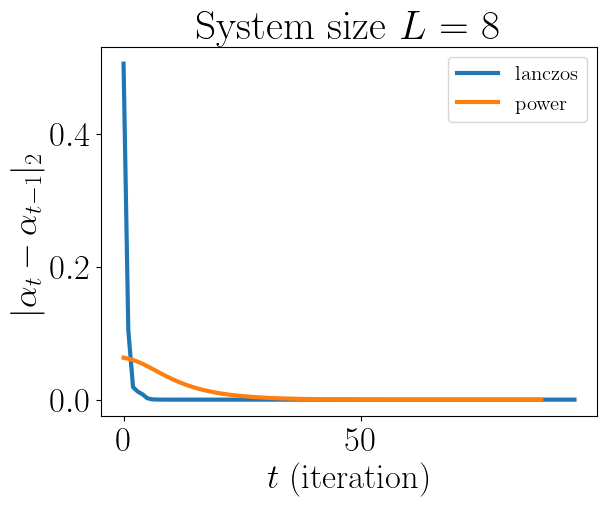

In [180]:
L = 8
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)

plt.plot(lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=True,reortho=True),linewidth=3,label='lanczos')
plt.plot(power_method(H, ITER=100,conv_check_state = True),linewidth=3,label='power')
plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$t$ (iteration)')
plt.ylabel(r'$|\alpha_t - \alpha_{t-1}|_2$')
plt.title(r'System size $L$ = ' + str(L))

100%|██████████| 100/100 [00:00<00:00, 114.46it/s]


Text(0.5, 1.0, 'System size $L$ = 10')

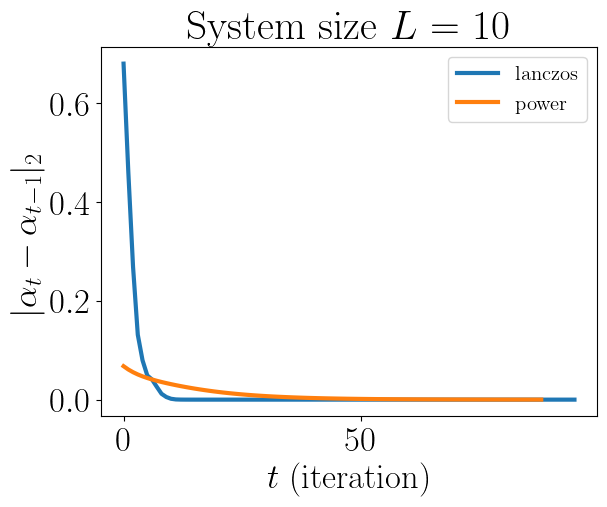

In [181]:
L = 10
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)

plt.plot(lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=True,reortho=True),linewidth=3,label='lanczos')
plt.plot(power_method(H, ITER=100,conv_check_state = True),linewidth=3,label='power')
plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$t$ (iteration)')
plt.ylabel(r'$|\alpha_t - \alpha_{t-1}|_2$')
plt.title(r'System size $L$ = ' + str(L))

100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Text(0.5, 1.0, 'System size $L$ = 12')

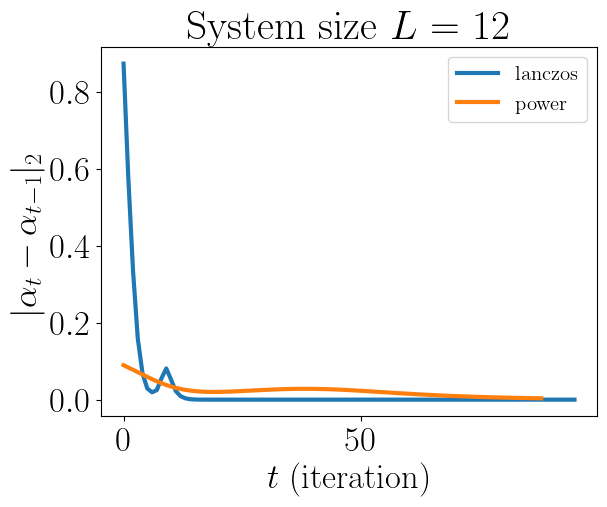

In [182]:
L = 12
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)

plt.plot(lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=True,reortho=True),linewidth=3,label='lanczos')
plt.plot(power_method(H, ITER=100,conv_check_state = True),linewidth=3,label='power')
plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$t$ (iteration)')
plt.ylabel(r'$|\alpha_t - \alpha_{t-1}|_2$')
plt.title(r'System size $L$ = ' + str(L))

Thus, it is clear that the Lanczos method converges faster than the power method. Let us check _without_ reorthogonalizing.

100%|██████████| 100/100 [00:00<00:00, 1477.43it/s]


Text(0.5, 1.0, 'System size $L$ = 8')

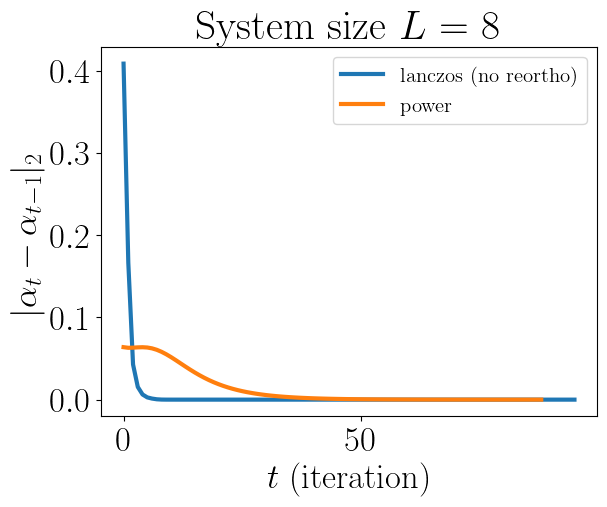

In [183]:
L = 8
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)

plt.plot(lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=True,reortho=False),linewidth=3,label='lanczos (no reortho)')
plt.plot(power_method(H, ITER=100,conv_check_state = True),linewidth=3,label='power')
plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$t$ (iteration)')
plt.ylabel(r'$|\alpha_t - \alpha_{t-1}|_2$')
plt.title(r'System size $L$ = ' + str(L))

100%|██████████| 100/100 [00:01<00:00, 83.59it/s]


Text(0.5, 1.0, 'System size $L$ = 10')

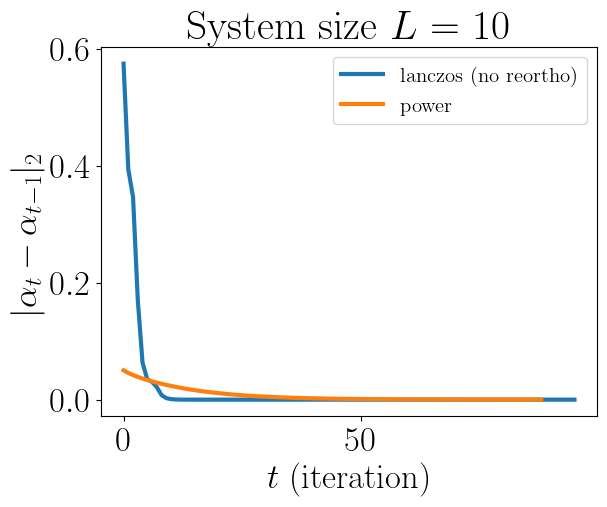

In [184]:
L = 10
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)

plt.plot(lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=True,reortho=False),linewidth=3,label='lanczos (no reortho)')
plt.plot(power_method(H, ITER=100,conv_check_state = True),linewidth=3,label='power')
plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$t$ (iteration)')
plt.ylabel(r'$|\alpha_t - \alpha_{t-1}|_2$')
plt.title(r'System size $L$ = ' + str(L))

100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Text(0.5, 1.0, 'System size $L$ = 12')

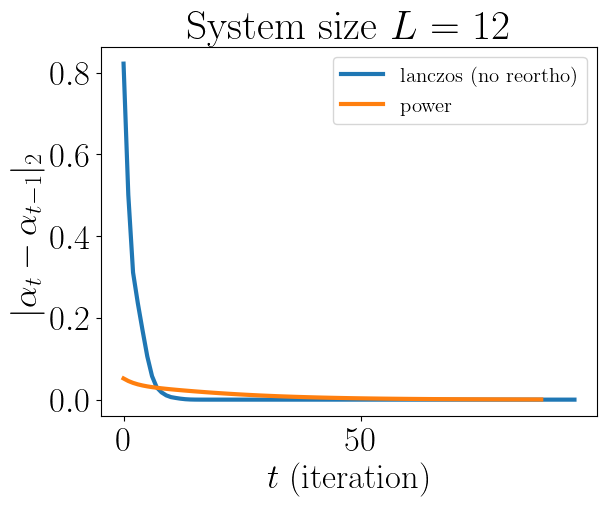

In [185]:
L = 12
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)

plt.plot(lanczos(H,ITER=100,conv_check_show=False,conv_check_eig=True,reortho=False),linewidth=3,label='lanczos (no reortho)')
plt.plot(power_method(H, ITER=100,conv_check_state = True),linewidth=3,label='power')
plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$t$ (iteration)')
plt.ylabel(r'$|\alpha_t - \alpha_{t-1}|_2$')
plt.title(r'System size $L$ = ' + str(L))

Thus while reorthogonalization does not affect convergence rates that much, it definitely affects correctness as we've seen before.

# interesting point
I now wish to point out a tricky situation which happens with these methods for small system sizes $L\approx 4$. While I've shown that the code for lanczos is very stable for large sizes, it is prone to `over-iterating' in smaller sizes. While, I think the power method does not have any such issues. Let us do this for $L=4$ . 

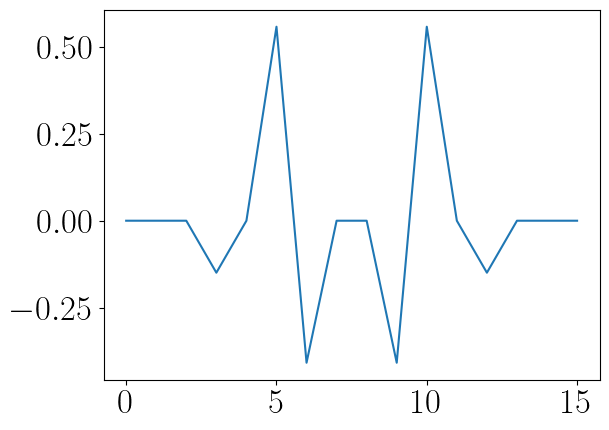

In [195]:
L = 4
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)
eigenvalues, eigenvectors = np.linalg.eig(H)

sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
actual_gs = sorted_eigenvectors[:,0] 
plt.plot(actual_gs)

In [201]:
sorted_eigenvalues

array([-1.6160254 , -0.95710678, -0.95710678, -0.95710678, -0.25      ,
       -0.25      , -0.25      ,  0.1160254 ,  0.45710678,  0.45710678,
        0.45710678,  0.75      ,  0.75      ,  0.75      ,  0.75      ,
        0.75      ])

100%|██████████| 100/100 [00:00<00:00, 7675.83it/s]


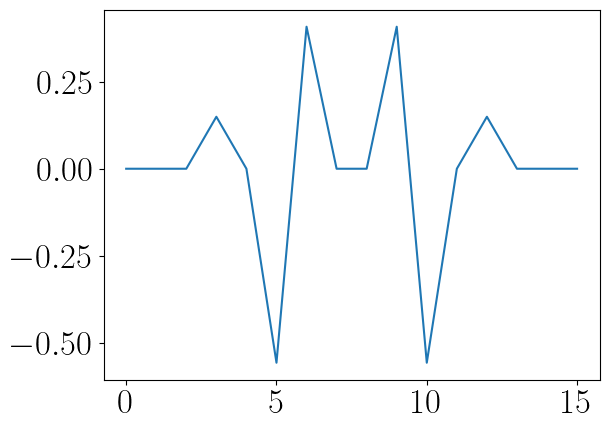

In [200]:
power_gs = power_method(H, ITER=100,conv_check_state = False)
plt.plot(power_gs)


Thus the power method returns very close to the true eigenket.

100%|██████████| 20/20 [00:00<00:00, 3117.28it/s]


Text(0, 0.5, '$E$')

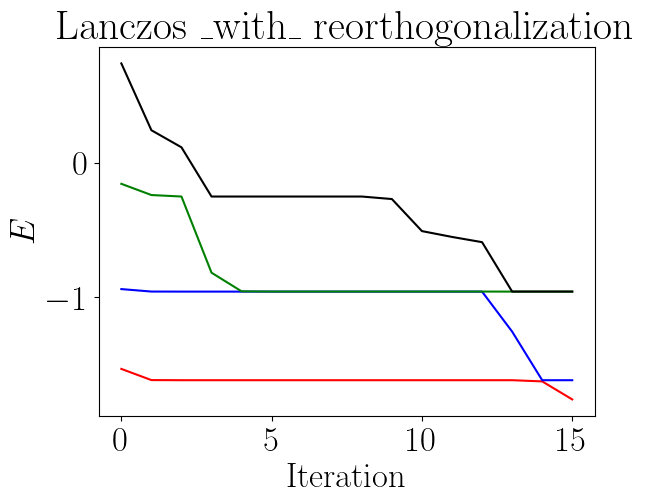

In [188]:
arr1, arr2, arr3, arr4 = lanczos(H,ITER=20,conv_check_show=True,conv_check_eig=False,reortho=True)
plt.title('Lanczos _with_ reorthogonalization')
plt.plot(arr1,color='red')
plt.plot(arr2,color='blue')
plt.plot(arr3,color='green')
plt.plot(arr4,color='black')
plt.xlabel('Iteration')
plt.ylabel('$E$')

The Lanczos returns the correct eigenvalues if run for 10-15 iterations (g.s. $\approx -1.6$ ). Let's run it for more.

100%|██████████| 100/100 [00:00<00:00, 276.90it/s]


Text(0, 0.5, '$E$')

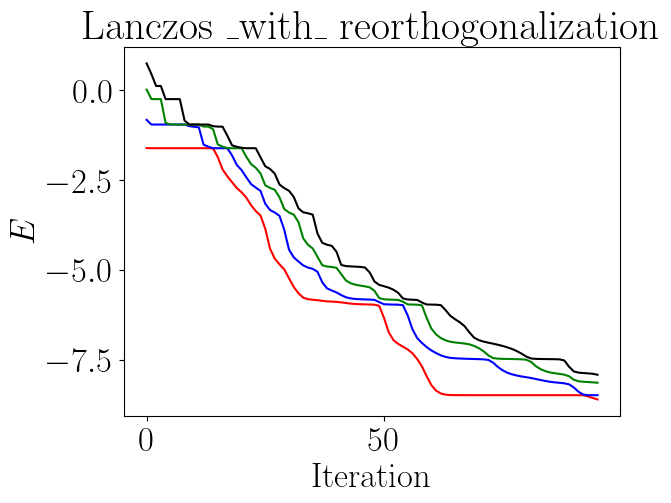

In [202]:
arr1, arr2, arr3, arr4 = lanczos(H,ITER=100,conv_check_show=True,conv_check_eig=False,reortho=True)
plt.title('Lanczos _with_ reorthogonalization')
plt.plot(arr1,color='red')
plt.plot(arr2,color='blue')
plt.plot(arr3,color='green')
plt.plot(arr4,color='black')
plt.xlabel('Iteration')
plt.ylabel('$E$')

Overconvergence!! This shhould be kept in mind. I don't think it's a bug, as it does not happen for large Hamiltonians.

Whereas, for a larger system, the lanczos performance is correct, as can be seen as follows:

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Text(0, 0.5, '$E$')

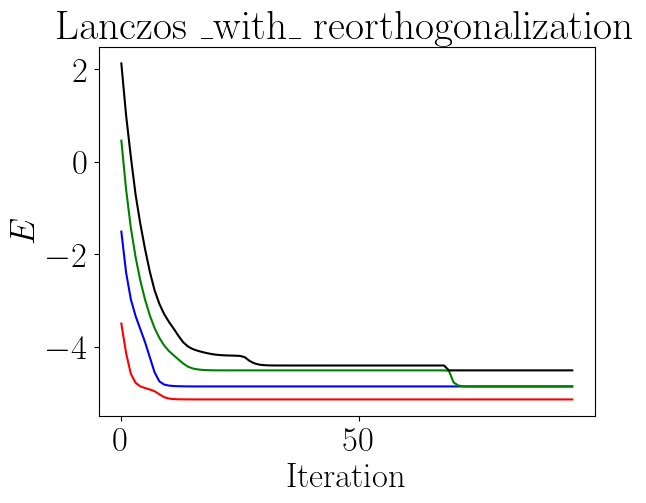

In [76]:
L = 12
J = 1
state_dict = create_statedict(L=L)
H = heisen_hamil(L=L,J=J,state_dict=state_dict)
arr1, arr2, arr3, arr4 = lanczos(H,ITER=100,conv_check_show=True,conv_check_eig=False,reortho=True)
plt.title('Lanczos _with_ reorthogonalization')
plt.plot(arr1,color='red')
plt.plot(arr2,color='blue')
plt.plot(arr3,color='green')
plt.plot(arr4,color='black')
plt.xlabel('Iteration')
plt.ylabel('$E$')

## Problem 2: (10 marks)

Diagonalize a 2-site Bose-Hubbard model
\begin{equation}
\mathcal{H} = -t \left(b^\dagger_1 b_2 + b^\dagger_2 b_1 \right) + U \sum_{i=1,2} \left(n_i - N_0 \right)^2
\end{equation}
Plot ground state number density $\langle n_i \rangle$, number fluctuations $\sqrt{\langle n^2_i \rangle - \langle n_i \rangle^2}$ versus $\frac{U}{t} \in (0.,4.)$  for $N_0=\{0.5,1,1.5,2\}$. Comment on your results. Study/Plot any other relevant quantity you can think of based on your comments.

The _Hilbert space_ is truncated to some band around $N_0$. 


Let $\mathcal{H} = \{\ket{0},\ket{1},\ket{2}, \dots, \ket{m-1}\} \otimes \{\ket{0},\ket{1},\ket{2}, \dots, \ket{m-1}\}$ as our $N_0$ is fairly small, so we truncate only on the upper side.

Note that 
$$b^{\dagger}\ket{n} = \sqrt{n+1}\ket{n+1},~b\ket{n} = \sqrt{n}\ket{n-1}$$

Thus, 
$$(b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2} = \sqrt{n_2(n_1+1)}\ket{n_1+1,n_2-1} + \sqrt{n_1(n_2+1)}\ket{n_1-1,n_2+1}$$
$$\implies \bra{n_1',n_2'}(b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2} = \sqrt{n_2(n_1+1)}\delta_{n_1',n_1+1}\delta_{n_2',n_2-1}+ \sqrt{n_1(n_2+1)}\delta_{n_1',n_1-1}\delta_{n_2',n_2+1}$$
Thus this part is strictly non-diagonal in the basis.

Also note that $(n_i - N_0)^2=n_i^2 + N_0^2 - 2N_0n_i$ is diagonal in the computational basis, thus only diagonal terms contribute, and
$$\bra{n_1,n_2}(\hat{n}_1 - N_0)^2 + (\hat{n}_2 - N_0)^2\ket{n_1,n_2} = (n_1-N_0)^2 + (n_2 - N_0)^2$$

In [7]:
def BH_hamil(t,U,N_0,m=5):
    single_space = [i for i in range(m)] #single particle basis states truncated 0,1,...,m-1
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))]) #tensor product two-site basis states
    dim = len(tensor_states) 

    H = np.zeros((dim,dim))

    for index in range(dim):
        #diagonal part first
        state = tensor_states[index]
        n1, n2 = state[0], state[1]
        H[index,index] = U * ((n1 - N_0) ** 2 + (n2 - N_0) ** 2) #only the repulsion term at each site
        #non-diagonal part
        if n1 == 0 and n2 == 0:
            #both terms in (b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2} die out
            pass
        elif n1 == 0 and n2 != 0:
            #only the first term in (b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2} = (b_1^{\dagger}b_2)\ket{n_1,n_2} survives
            # need the state [1,n2-1]
            newstate = [1,n2-1]
            flipindex = m * (newstate[1]) + newstate[0]  # for a state in tensor_states, the index can be found directly by m * (state[1]) + state[0] owing to the construction
            H[flipindex,index] += -t * sqrt(n2)
        elif n2 == 0 and n1 != 0:
            #only the second term in (b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2} = ( b_2^{\dagger}b_1)\ket{n_1,n_2} survives
            # need the state [n1-1,1]
            newstate = [n1-1,1]
            flipindex = m * (newstate[1]) + newstate[0] 
            H[flipindex,index] += -t * sqrt(n1)
        else:#both n1 and n2 nonzero
            if n1 == m-1 and n2 == m-1: #as we do not want to go out of our truncation
                pass 
            elif n1 == m-1 and n2 < m-1:
                #only the second term in (b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2} =  ( b_2^{\dagger}b_1)\ket{n_1,n_2} survives
                newstate = [n1-1,n2+1]
                flipindex = m * (newstate[1]) + newstate[0] 
                H[flipindex,index] += -t * sqrt((n2+1)*n1)
            elif n2 == m-1 and n1 < m-1:
                #only the first term in (b_1^{\dagger}b_2 + b_2^{\dagger}b_1)\ket{n_1,n_2}  
                newstate = [n1+1,n2-1]
                flipindex = m * (newstate[1]) + newstate[0] 
                H[flipindex,index] += -t * sqrt((n1+1)*n2)
            else: # both 0 < n1,n2 < m-1 so both terms enter
                newstate = [n1+1,n2-1]
                flipindex = m * (newstate[1]) + newstate[0] 
                H[flipindex,index] += -t * sqrt((n1+1)*n2)

                newstate = [n1-1,n2+1]
                flipindex = m * (newstate[1]) + newstate[0] 
                H[flipindex,index] += -t * sqrt((n2+1)*n1)

    return H


def num_density(psi,tensor_states):
    #given a psi in the basis we defined above, compute its number density <ni>
    dim = len(psi)
    n1av = 0
    n2av = 0
    for index in range(dim):
        state = tensor_states[index]
        n1, n2 = state 
        n1av += n1 * np.abs(psi[index]) ** 2
        n2av += n2 * np.abs(psi[index]) ** 2
    return n1av, n2av 

def num_density_sq(psi,tensor_states):
    #given a psi in the basis we defined above, compute its number density square <ni^2>
    dim = len(psi)
    n1av = 0
    n2av = 0
    for index in range(dim):
        state = tensor_states[index]
        n1, n2 = state 
        n1av += n1**2 * np.abs(psi[index]) ** 2
        n2av += n2**2 * np.abs(psi[index]) ** 2
    return n1av, n2av 

def fluctuations(psi,tensor_states):
    n1av, n2av = num_density(psi,tensor_states)
    n1avsq, n2avsq = num_density_sq(psi,tensor_states)
    return sqrt(n1avsq - n1av**2), sqrt(n2avsq - n2av**2) 

def gs(H):
    #get gs of H
    eigenvalues, eigenvectors = np.linalg.eig(H)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    gs = sorted_eigenvectors[:,0]
    return gs


(<Figure size 800x600 with 2 Axes>, <Axes: >)

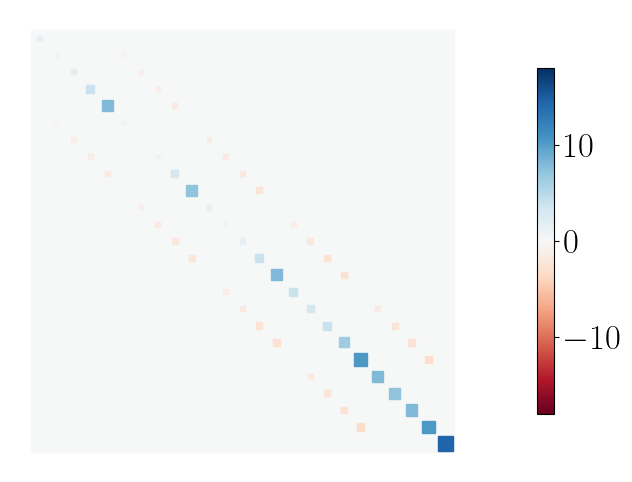

In [6]:
# a first look 
m = 5
single_space = [i for i in range(m)]
tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
dim = len(tensor_states)
h = BH_hamil(t=1,U=1,N_0=1,m=5)
hinton(h)


The BH Hamiltonian is indeed very sparse, almost like a tri-diagonal matrix. But since we will see that we can get the correct physics from small truncations $m \approx 15-20$, we will not apply any further efficient sparse methods here. But for multi-site (and/or $U/t \ll 1$) one can see how that would become crucial.

# First, let us do some truncation/convergence checks!

We need to be sure that our selection of $m$ is correct to answer things about the physics of the system, so we first check this.

Text(0.5, 1.0, 'ConvCheck:   $U = $0  $t = $1  $N_0 = $0.5')

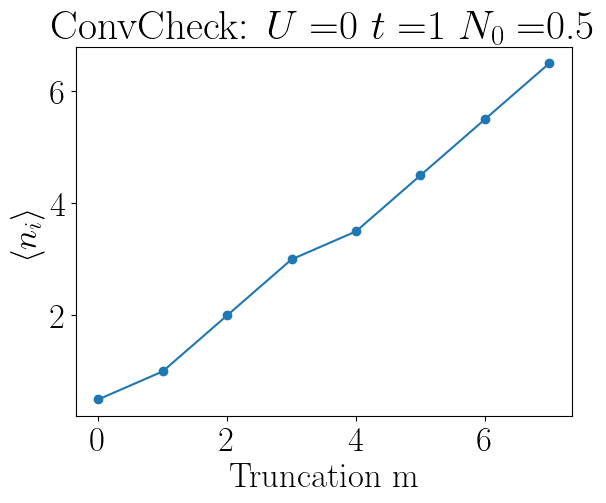

In [134]:
t = 1 
U = 0
N_0 = 0.5
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in range(2,10):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


Thus for $U = 0$ the convergence is tough. Let's try increasing $m$.


100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


Text(0.5, 1.0, 'ConvCheck:   $U = $0  $t = $1  $N_0 = $0.5')

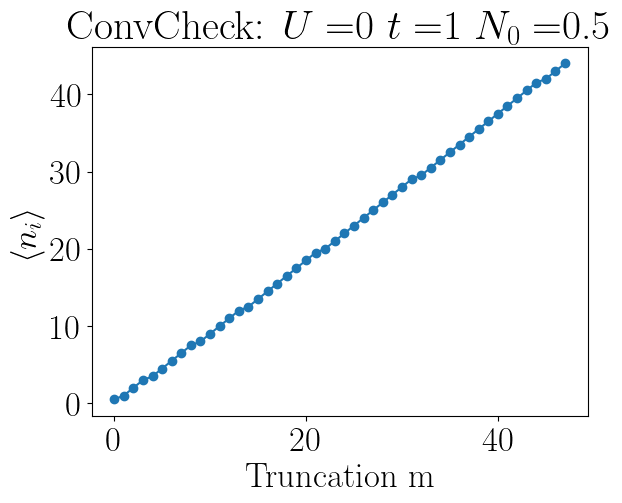

In [9]:
t = 1 
U = 0
N_0 = 0.5
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in tqdm(range(2,50)):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


Does not converge at all!! Let's try for small $U>0$.

Text(0.5, 1.0, 'ConvCheck:   $U = $0.05  $t = $1  $N_0 = $0.5')

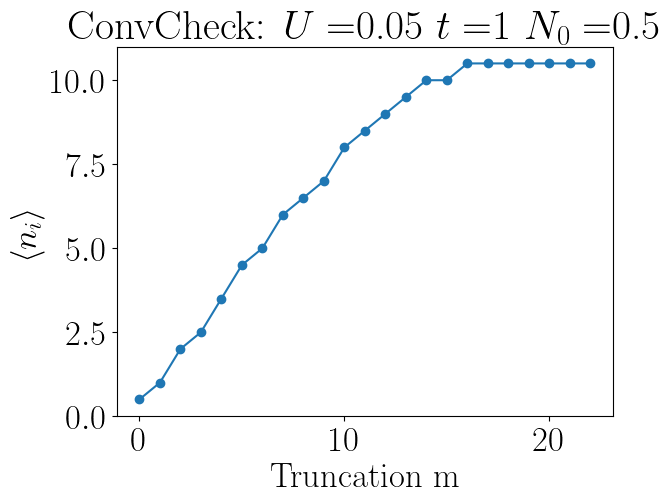

In [11]:
t = 1 
U = 0.05
N_0 = 0.5
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in range(2,25):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


Text(0.5, 1.0, 'ConvCheck:   $U = $0.1  $t = $1  $N_0 = $0.5')

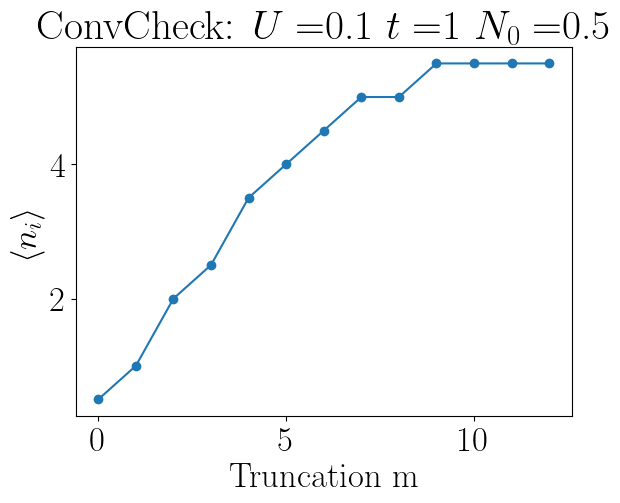

In [140]:
t = 1 
U = 0.1
N_0 = 0.5
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in range(2,15):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


$\implies$ smaller $U/t$ requires bigger truncation sizes!! as expected :)

Text(0.5, 1.0, 'ConvCheck:   $U = $1  $t = $1  $N_0 = $0.5')

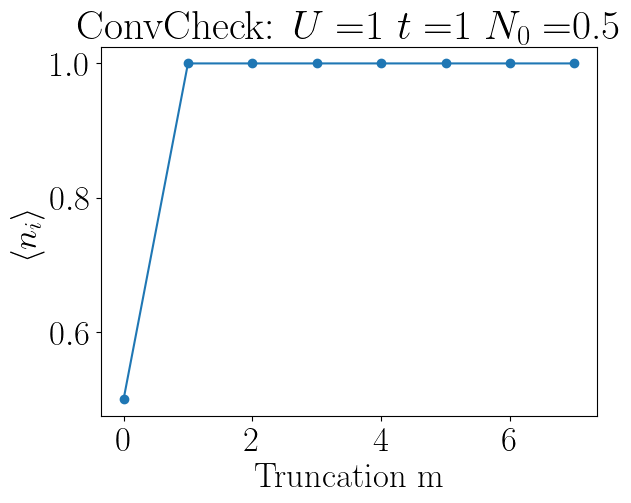

In [135]:
t = 1 
U = 1
N_0 = 0.5
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in range(2,10):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


$\implies$ truncation converges quite fast when $U > 0$

Text(0.5, 1.0, 'ConvCheck:   $U = $1  $t = $1  $N_0 = $1')

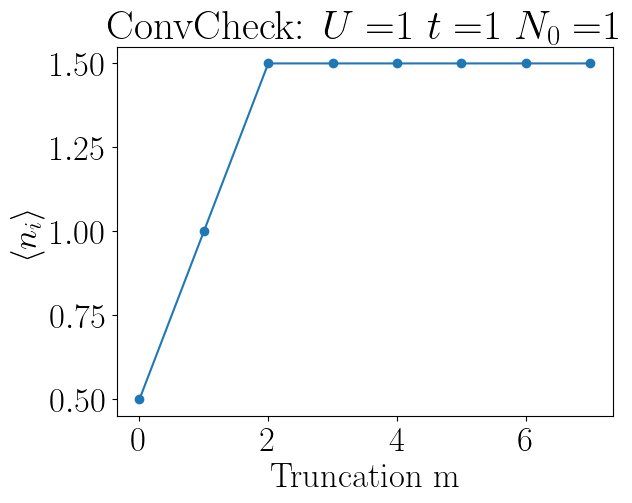

In [137]:
t = 1 
U = 1
N_0 = 1
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in range(2,10):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


$\implies $ the number average changes as per $N_0$ to minimize repulsion

Text(0.5, 1.0, 'ConvCheck:   $U = $1  $t = $1  $N_0 = $2')

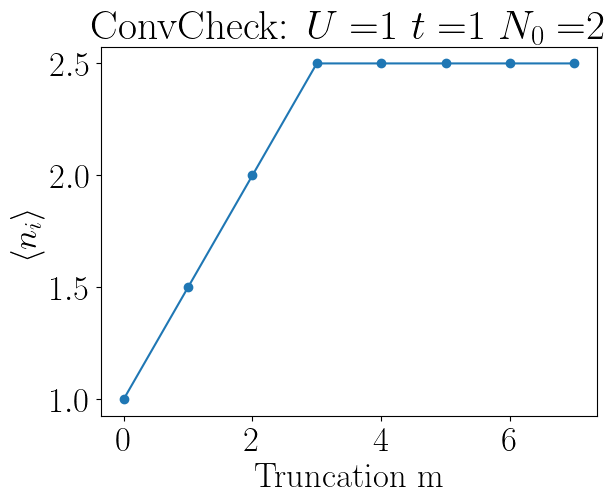

In [138]:
t = 1 
U = 1
N_0 = 2
H = BH_hamil(t,U,N_0,m=5)

arr = []
for m in range(2,10):
    m = int(m)
    single_space = [i for i in range(m)]
    tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
    dim = len(tensor_states)
    H = BH_hamil(t,U,N_0,m=m)
    arr.append(num_density(gs(H),tensor_states)[0])

plt.plot(arr,"-o")
plt.xlabel('Truncation m')
plt.ylabel(r'$\langle n_i \rangle$')
plt.title('ConvCheck: ' + r'  $U = $' +str(U) + r'  $t = $' + str(t) + r'  $N_0 = $' + str(N_0))


Thus for $U/t = \mathcal{O}(1)$ we need very small $m$ for very small $N_0$.

# Now the G.S. number density and fluctuations

100%|██████████| 20/20 [00:06<00:00,  2.91it/s]

For U/t = 4 we have that num-avg is 0.49999999999981526 and num fluct is 0.5


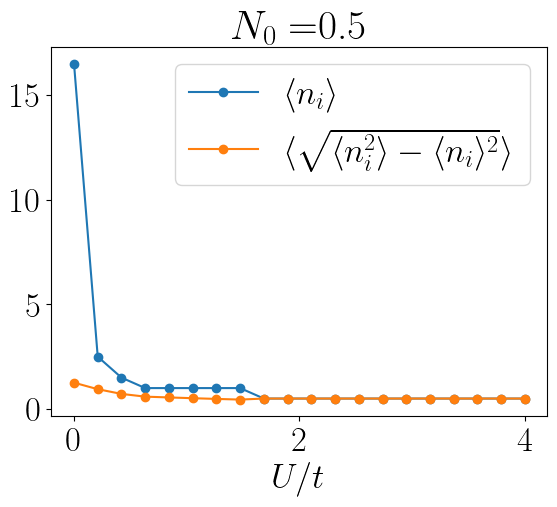

In [13]:
N_0 =0.5

t = 1 
m = 20 # keep high to avoid any numerical errors 
H = BH_hamil(t,U,N_0,m=5)
U_arr = np.linspace(0,4,20)
arr1 = []
arr2 = []
single_space = [i for i in range(m)]
tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
dim = len(tensor_states)

for U in tqdm(U_arr):
    H = BH_hamil(t=t,U=U,N_0=N_0,m=m)
    arr1.append((num_density(gs(H),tensor_states))[0])
    arr2.append((fluctuations(gs(H),tensor_states))[0])

plt.plot(U_arr, arr1,"-o",label=r'$\langle n_i \rangle$')
plt.plot(U_arr,arr2, "-o",label=r'$\langle \sqrt{\langle n_i^2\rangle - \langle n_i\rangle^2} \rangle$')

plt.xlabel(r'$U/t$')
plt.title( r'  $N_0 = $' + str(N_0))
plt.legend()

print("For U/t = 4 we have that num-avg is " + str(arr1[-1]) + " and num fluct is " + str(arr2[-1]) )

The first data point thus might not be _very_ trust-worthy, as we noted before.

100%|██████████| 20/20 [00:06<00:00,  3.00it/s]

For U/t = 4 we have that num-avg is 0.9999999999999998 and num fluct is 0.22975292054736182


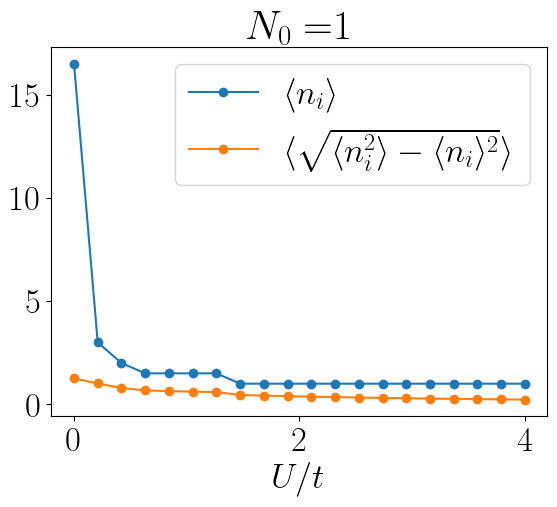

In [14]:
N_0 = 1

t = 1 
m = 20 # keep high to avoid any numerical errors 
H = BH_hamil(t,U,N_0,m=5)
U_arr = np.linspace(0,4,20)
arr1 = []
arr2 = []
single_space = [i for i in range(m)]
tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
dim = len(tensor_states)

for U in tqdm(U_arr):
    H = BH_hamil(t=t,U=U,N_0=N_0,m=m)
    arr1.append((num_density(gs(H),tensor_states))[0])
    arr2.append((fluctuations(gs(H),tensor_states))[0])

plt.plot(U_arr, arr1,"-o",label=r'$\langle n_i \rangle$')
plt.plot(U_arr,arr2, "-o",label=r'$\langle \sqrt{\langle n_i^2\rangle - \langle n_i\rangle^2} \rangle$')

plt.xlabel(r'$U/t$')
plt.title( r'  $N_0 = $' + str(N_0))
plt.legend()
print("For U/t = 4 we have that num-avg is " + str(arr1[-1]) + " and num fluct is " + str(arr2[-1]) )

100%|██████████| 20/20 [00:06<00:00,  2.96it/s]

For U/t = 4 we have that num-avg is 1.4999999999999278 and num fluct is 0.517705991792673


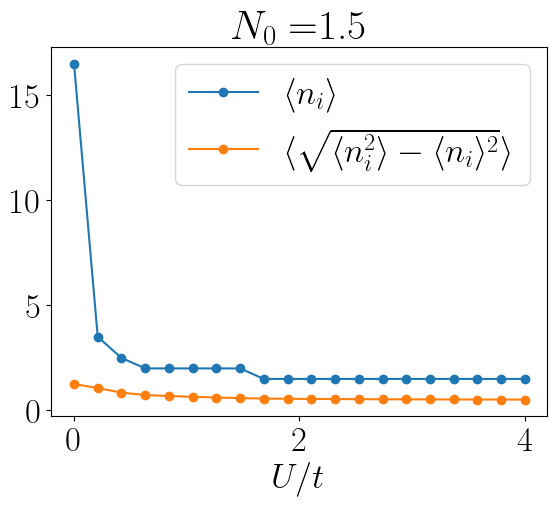

In [15]:
N_0 =1.5

t = 1 
m = 20 # keep high to avoid any numerical errors 
H = BH_hamil(t,U,N_0,m=5)
U_arr = np.linspace(0,4,20)
arr1 = []
arr2 = []
single_space = [i for i in range(m)]
tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
dim = len(tensor_states)

for U in tqdm(U_arr):
    H = BH_hamil(t=t,U=U,N_0=N_0,m=m)
    arr1.append((num_density(gs(H),tensor_states))[0])
    arr2.append((fluctuations(gs(H),tensor_states))[0])

plt.plot(U_arr, arr1,"-o",label=r'$\langle n_i \rangle$')
plt.plot(U_arr,arr2, "-o",label=r'$\langle \sqrt{\langle n_i^2\rangle - \langle n_i\rangle^2} \rangle$')

plt.xlabel(r'$U/t$')
plt.title( r'  $N_0 = $' + str(N_0))
plt.legend()
print("For U/t = 4 we have that num-avg is " + str(arr1[-1]) + " and num fluct is " + str(arr2[-1]) )

100%|██████████| 20/20 [00:06<00:00,  3.03it/s]

For U/t = 4 we have that num-avg is 2.0 and num fluct is 0.3552996995923313


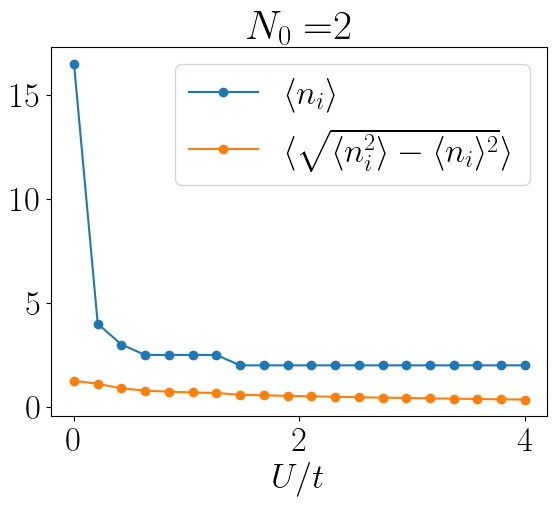

In [16]:
N_0 = 2

t = 1 
m = 20 # keep high to avoid any numerical errors 
H = BH_hamil(t,U,N_0,m=5)
U_arr = np.linspace(0,4,20)
arr1 = []
arr2 = []
single_space = [i for i in range(m)]
tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
dim = len(tensor_states)

for U in tqdm(U_arr):
    H = BH_hamil(t=t,U=U,N_0=N_0,m=m)
    arr1.append((num_density(gs(H),tensor_states))[0])
    arr2.append((fluctuations(gs(H),tensor_states))[0])

plt.plot(U_arr, arr1,"-o",label=r'$\langle n_i \rangle$')
plt.plot(U_arr,arr2, "-o",label=r'$\langle \sqrt{\langle n_i^2\rangle - \langle n_i\rangle^2} \rangle$')

plt.xlabel(r'$U/t$')
plt.title( r'  $N_0 = $' + str(N_0))
plt.legend()
print("For U/t = 4 we have that num-avg is " + str(arr1[-1]) + " and num fluct is " + str(arr2[-1]) )

Thus we note that for any $N_0$, the average number density is close to $\lfloor N_0\rfloor$ to minimize repulsion. Further, for non-integer $N_0$, the fluctuations are larger and of the magnitude $|N_0 - \lfloor N_0\rfloor|$ as the density tries to approach $N_0$. For integer $N_0$, the fluctuations are slower and will die out totally as $U/t \to \infty$.

# Supplementary curiosity

Ground state entanglement entropies of many-body Hamiltonians are typically used to signify phase transitions/ topological phases. In this exercise, I will try doing this for the BH model truncated to $m=2$ (thus, hard-core Bosons). This is the first time I am numerically simulating the BH model, so curious to see the result.

## the von-Neumann entropy
For a bipartite pure state $\ket{\psi}\in \mathcal{H}^{AB}$, a measure of entanglement is the bipartite entanglement entropy. This is defined as,
$$E(\psi) := S(\rho_A) := -\text{Tr}\rho_A\log\rho_A$$
where 
$$\rho_A := \text{Tr}_B\ket{\psi^{AB}}\bra{\psi^{AB}}$$

In [58]:
m = 2
single_space = [i for i in range(m)]
tensor_states = np.transpose([np.tile(single_space, len(single_space)), np.repeat(single_space, len(single_space))])
dim = len(tensor_states)
t = 1 
U_arr = np.linspace(0,2,250)
N_0_arr = np.linspace(0,2,250)
mat = np.zeros((len(U_arr),len(N_0_arr)))

for i, U in tqdm(enumerate(U_arr)):
    for j, N_0 in enumerate(N_0_arr):
        H = BH_hamil(t,U,N_0,m=2)
        psi = Qobj(gs(H),dims=[[2, 2], [1, 1]]) #get g.s. w.f.
        rho = Qobj(gs(H),dims=[[2, 2], [1, 1]]).ptrace(0) #trace out one particle
        entr = entropy_vn(rho)/0.693 #compute v-n entropy in bits
        mat[i,j] = entr

250it [00:33,  7.53it/s]


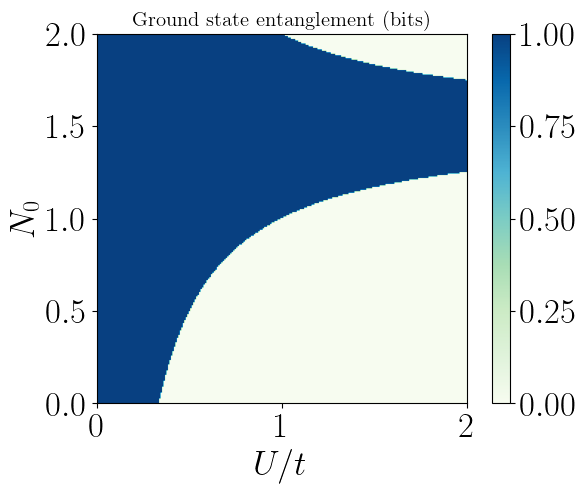

In [60]:
plt.imshow(np.transpose(mat),cmap='GnBu',extent=[0,2,0,2])
plt.xlabel(r'$U/t$')
plt.ylabel(r'$N_0$')
plt.title('Ground state entanglement (bits)',fontsize=15)
plt.colorbar()

Question for later: what do the boundaries signify? It can be seen that if $S = 1$, the ground state of the Hamiltonian is in-fact a Bell-pair, one of the four maximally entangled two-qubit states. Interesting.

## Problem 3.  (10 marks)

1.Compute, tabulate and plot the specific heat $\left( C(T,H) \equiv \frac{d\langle E \rangle(T',H')}{dT'}|_{T,H} \right)$ and (uniform) magnetic susceptibility $\left( \chi(T,H) \equiv \frac{d\langle M_z \rangle(T',H')}{dH'}|_{T,H} \right)$ vs. temperature ($T$) in zero field ($H=0$) for spin-$\frac{1}{2}$ antiferromagnetic Heisenberg chains with even number of spins up to 12 or greater and periodic boundary conditions,
\begin{equation} \mathcal{H}=  J\sum\limits_{\langle i,j \rangle} \hat{\mathbf{S}}_{i}\cdot\hat{\mathbf{S}}_{j} \end{equation}
where $\langle i,j \rangle$ denotes the set of nearest neigbour bonds. $M_z$ is total magnetization along the $z$-axis.


2.Redo the above for spin-$\frac{1}{2}$ antiferromagnetic Ising chains with even number of spins up to 12 or greater and periodic boundary conditions,
\begin{equation} \mathcal{H}=  J_z \sum\limits_{\langle i,j \rangle} \hat{S}^z_{i}\cdot\hat{S}^z_{j} \end{equation}

3.Comment on the above results.

Useful formulas from statistical physics: 

$$ C(T,H)  =  \frac{1}{T^2} \left(\langle \mathcal{H}^2 \rangle - \langle \mathcal{H} \rangle^2 \right)  $$
$$ \chi(T,H)  =  \frac{1}{T} \left(\langle M_z^2 \rangle - \langle M_z \rangle^2 \right) $$
where all the expectation values above on the right hand sides are functions of $T$ and $H$. You can take the Boltzmann constant $k_B=1$ throughout.

# part 1: for the normal full chain

In [24]:
#standard sub-routines from tutorialls and class
def find_ind(state,lookups):
    #state is in binary
    mag = sum_str(state)
    lookup = lookups[mag]
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(lookup[mid],2) < int(state,2):
            low = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) > int(state,2):
            high = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) == int(state,2):
            return mag, mid 
        
def create_mag_lookups(L,state_dict):
    lookups = {}
    for mag in range(-L,L+1):
        ctr = 0
        lookup = {}
        for i in range(2**L):
            state = state_dict[i]
            if sum_str(state) == mag:
                lookup[ctr] = state 
                ctr += 1
        lookups[mag] = lookup
    return lookups


def create_hamil_mag(L,J,mag,lookups):
    lookup = lookups[mag]
    dim = len(lookup)
    ham = np.zeros((dim,dim))
    for site in range(L):
        for i in range(dim):
            state = lookup[i]
            #diagonal part
            s_site = 2 * int(state[site]) - 1
            s_nextsite = 2 * int(state[(site+1)%L]) - 1 
            ham[i,i] += s_site * s_nextsite * 1/4

            #off-diagonal part
            if state[site] != state[(site+1)%L]:
                nextstate = flipbits(state,site,(site+1)%L) # will always be in the same magnetization sector!
                mag_, j = find_ind(nextstate,lookups)
                if mag != mag_:
                    return "ERROR ERROR!!"
                ham[i,j] += 1/2
    return ham * J

/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_1137/3162421010.py:3: RuntimeWarning: overflow encountered in exp
  return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_1137/3162421010.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_1137/3162421010.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])


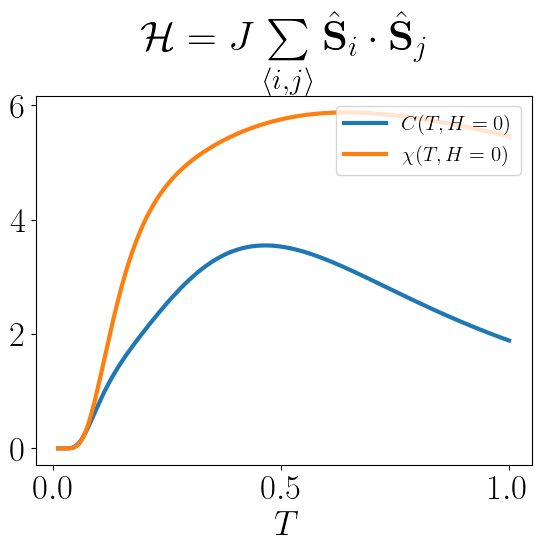

In [65]:
def take_av(arr,energy_arr,T_arr): 
    '''computes the average of arr Boltzmann distributed with energies from energy_arr for temperature grid T_Arr'''
    return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
L = 10
J = 1
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
hamils = [create_hamil_mag(L,J,mag,lookups) for mag in range(-L,L+1)] #set of mz hamiltonians for all mz

# four arrays to store all E, E^2, M, M^2
all_energies = []
all_energies_squared = []
all_mags = []
all_mags_squared = []

# to compute those arrays, we first loop over all magnetizations and then individually diagonalize
for i, mag in enumerate(range(-L,L+1)):
    lenn = len(lookups[mag])
    all_mags += [mag] * lenn #store constant mag repeated len times as the magnetization is same inside a sector
    all_mags_squared += [mag ** 2] * lenn  # same for square
    h_mag = hamils[i]
    eigenvalues ,_ = np.linalg.eigh(h_mag) 
    for eval in eigenvalues:
        all_energies.append(eval)  #store eigenvals from diagonalization
        all_energies_squared.append(eval ** 2)  #same from square

#make numpy all
all_energies = np.array(all_energies)
all_energies_squared = np.array(all_energies_squared)
all_mags = np.array(all_mags)
all_mags_squared = np.array(all_mags_squared)


T_arr = np.linspace(0.001,1.0,200) #for evaluating \chi and C

avE = take_av(all_energies,all_energies,T_arr)
avEsq = take_av(all_energies_squared,all_energies,T_arr)
avM = take_av(all_mags,all_energies,T_arr)
avMsq = take_av(all_mags_squared,all_energies,T_arr)

C_arr = (avEsq - avE ** 2) / T_arr ** 2
Chi_arr = (avMsq - avM ** 2) / T_arr 
plt.title(r'$ \mathcal{H}=  J\sum\limits_{\langle i,j \rangle} \hat{\mathbf{S}}_{i}\cdot\hat{\mathbf{S}}_{j}$')
plt.plot(T_arr,C_arr,label=r'$C(T,H=0)$',linewidth=3)
plt.plot(T_arr,Chi_arr,label=r'$\chi(T,H=0)$',linewidth=3)
plt.xlabel('$T$')
plt.legend(fontsize=15,loc='upper right')

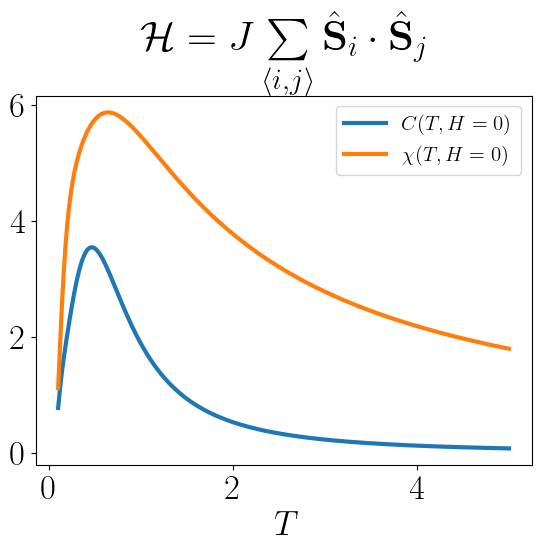

In [66]:
def take_av(arr,energy_arr,T_arr): 
    '''computes the average of arr Boltzmann distributed with energies from energy_arr for temperature grid T_Arr'''
    return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
L = 10
J = 1
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
hamils = [create_hamil_mag(L,J,mag,lookups) for mag in range(-L,L+1)] #set of mz hamiltonians for all mz

# four arrays to store all E, E^2, M, M^2
all_energies = []
all_energies_squared = []
all_mags = []
all_mags_squared = []

# to compute those arrays, we first loop over all magnetizations and then individually diagonalize
for i, mag in enumerate(range(-L,L+1)):
    lenn = len(lookups[mag])
    all_mags += [mag] * lenn #store constant mag repeated len times as the magnetization is same inside a sector
    all_mags_squared += [mag ** 2] * lenn  # same for square
    h_mag = hamils[i]
    eigenvalues ,_ = np.linalg.eigh(h_mag) 
    for eval in eigenvalues:
        all_energies.append(eval)  #store eigenvals from diagonalization
        all_energies_squared.append(eval ** 2)  #same from square

#make numpy all
all_energies = np.array(all_energies)
all_energies_squared = np.array(all_energies_squared)
all_mags = np.array(all_mags)
all_mags_squared = np.array(all_mags_squared)


T_arr = np.linspace(0.1,5.0,500) #for evaluating \chi and C

avE = take_av(all_energies,all_energies,T_arr)
avEsq = take_av(all_energies_squared,all_energies,T_arr)
avM = take_av(all_mags,all_energies,T_arr)
avMsq = take_av(all_mags_squared,all_energies,T_arr)

C_arr = (avEsq - avE ** 2) / T_arr ** 2
Chi_arr = (avMsq - avM ** 2) / T_arr 
plt.title(r'$ \mathcal{H}=  J\sum\limits_{\langle i,j \rangle} \hat{\mathbf{S}}_{i}\cdot\hat{\mathbf{S}}_{j}$')
plt.plot(T_arr,C_arr,label=r'$C(T,H=0)$',linewidth=3)
plt.plot(T_arr,Chi_arr,label=r'$\chi(T,H=0)$',linewidth=3)
plt.xlabel('$T$')
plt.legend(fontsize=15,loc='upper right')

# part 2: z-only H

In [26]:
# remake the mz hamiltonian function for the z-only hamiltonian
def create_hamil_mag_Zonly(L,J,mag,lookups):
    lookup = lookups[mag]
    dim = len(lookup)
    ham = np.zeros((dim,dim))
    for site in range(L):
        for i in range(dim):
            state = lookup[i]
            #diagonal part
            s_site = 2 * int(state[site]) - 1
            s_nextsite = 2 * int(state[(site+1)%L]) - 1 
            ham[i,i] += s_site * s_nextsite * 1/4

            #off-diagonal part does NOT exist
    return ham * J

/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_1137/4173385830.py:3: RuntimeWarning: overflow encountered in exp
  return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_1137/4173385830.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_1137/4173385830.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])


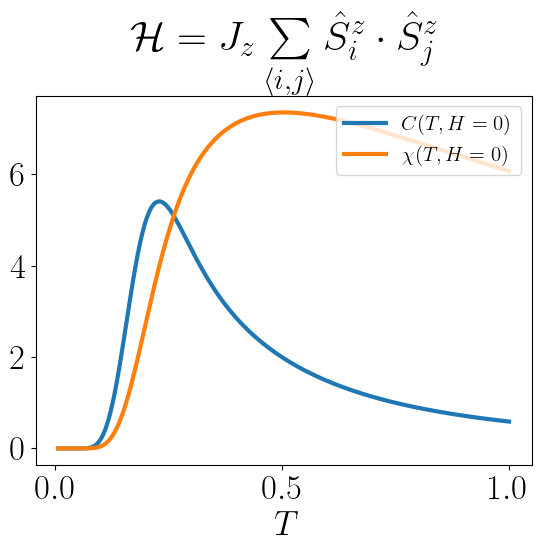

In [67]:
def take_av(arr,energy_arr,T_arr): 
    '''computes the average of arr Boltzmann distributed with energies from energy_arr for temperature grid T_Arr'''
    return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
L = 10
J = 1
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
hamils = [create_hamil_mag_Zonly(L,J,mag,lookups) for mag in range(-L,L+1)] #set of mz hamiltonians for all mz

# four arrays to store all E, E^2, M, M^2
all_energies = []
all_energies_squared = []
all_mags = []
all_mags_squared = []

# to compute those arrays, we first loop over all magnetizations and then individually diagonalize
for i, mag in enumerate(range(-L,L+1)):
    lenn = len(lookups[mag])
    all_mags += [mag] * lenn #store constant mag repeated len times as the magnetization is same inside a sector
    all_mags_squared += [mag ** 2] * lenn  # same for square
    h_mag = hamils[i]
    eigenvalues ,_ = np.linalg.eigh(h_mag) 
    for eval in eigenvalues:
        all_energies.append(eval)  #store eigenvals from diagonalization
        all_energies_squared.append(eval ** 2)  #same from square

#make numpy all
all_energies = np.array(all_energies)
all_energies_squared = np.array(all_energies_squared)
all_mags = np.array(all_mags)
all_mags_squared = np.array(all_mags_squared)


T_arr = np.linspace(0.001,1.0,200) #for evaluating \chi and C

avE = take_av(all_energies,all_energies,T_arr)
avEsq = take_av(all_energies_squared,all_energies,T_arr)
avM = take_av(all_mags,all_energies,T_arr)
avMsq = take_av(all_mags_squared,all_energies,T_arr)

C_arr = (avEsq - avE ** 2) / T_arr ** 2
Chi_arr = (avMsq - avM ** 2) / T_arr 
plt.title(r'$\mathcal{H}=  J_z \sum\limits_{\langle i,j \rangle} \hat{S}^z_{i}\cdot\hat{S}^z_{j}$')
plt.plot(T_arr,C_arr,label=r'$C(T,H=0)$',linewidth=3)
plt.plot(T_arr,Chi_arr,label=r'$\chi(T,H=0)$',linewidth=3)
plt.xlabel('$T$')
plt.legend(fontsize=15,loc='upper right')

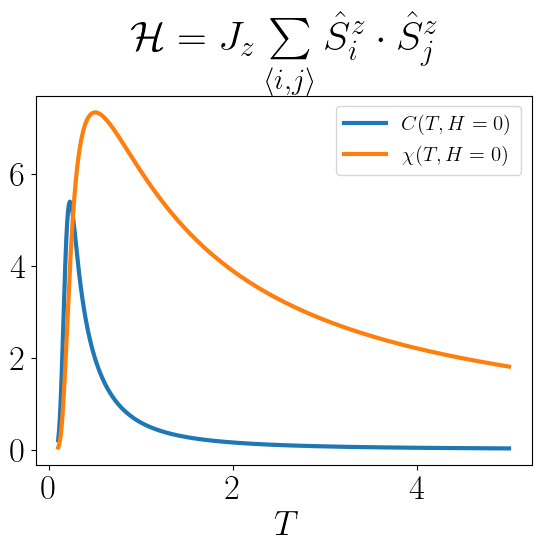

In [68]:
def take_av(arr,energy_arr,T_arr): 
    '''computes the average of arr Boltzmann distributed with energies from energy_arr for temperature grid T_Arr'''
    return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
L = 10
J = 1
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
hamils = [create_hamil_mag_Zonly(L,J,mag,lookups) for mag in range(-L,L+1)] #set of mz hamiltonians for all mz

# four arrays to store all E, E^2, M, M^2
all_energies = []
all_energies_squared = []
all_mags = []
all_mags_squared = []

# to compute those arrays, we first loop over all magnetizations and then individually diagonalize
for i, mag in enumerate(range(-L,L+1)):
    lenn = len(lookups[mag])
    all_mags += [mag] * lenn #store constant mag repeated len times as the magnetization is same inside a sector
    all_mags_squared += [mag ** 2] * lenn  # same for square
    h_mag = hamils[i]
    eigenvalues ,_ = np.linalg.eigh(h_mag) 
    for eval in eigenvalues:
        all_energies.append(eval)  #store eigenvals from diagonalization
        all_energies_squared.append(eval ** 2)  #same from square

#make numpy all
all_energies = np.array(all_energies)
all_energies_squared = np.array(all_energies_squared)
all_mags = np.array(all_mags)
all_mags_squared = np.array(all_mags_squared)


T_arr = np.linspace(0.1,5.0,500) #for evaluating \chi and C

avE = take_av(all_energies,all_energies,T_arr)
avEsq = take_av(all_energies_squared,all_energies,T_arr)
avM = take_av(all_mags,all_energies,T_arr)
avMsq = take_av(all_mags_squared,all_energies,T_arr)

C_arr = (avEsq - avE ** 2) / T_arr ** 2
Chi_arr = (avMsq - avM ** 2) / T_arr 
plt.title(r'$\mathcal{H}=  J_z \sum\limits_{\langle i,j \rangle} \hat{S}^z_{i}\cdot\hat{S}^z_{j}$')
plt.plot(T_arr,C_arr,label=r'$C(T,H=0)$',linewidth=3)
plt.plot(T_arr,Chi_arr,label=r'$\chi(T,H=0)$',linewidth=3)
plt.xlabel('$T$')
plt.legend(fontsize=15,loc='upper right')

*Observations*
- Both the systems show a much more skewed curve (at low $T < 1K$) for the heat-capacity as compared to the magnetic susceptibility.
- At higher temperatures, the heat-capacity also dies out much faster than the susceptibility.
- Thus, as the temperature increases the system becomes mixed in the eigenstates of energy, resulting in no response of average energy to temperature above $T \gtrsim 4K$
- Whereas, the magnetic properties depend on the external field for a much larger temperature range.
- Further, the heat-capacity is much more skewed (towards the left) in the Z system rather than the ZZZ system.
- Also, the system freezes ($C,\chi \approx 0$) at a higher temperature in the Z system than the ZZZ system, possibly due to more interactions in the former owing to spin-exchange in all three directions!
- Additionally, for a very large $T \gg 1$ plot shown below, we see that $\chi \not\to 0$, it saturates to some constant value.

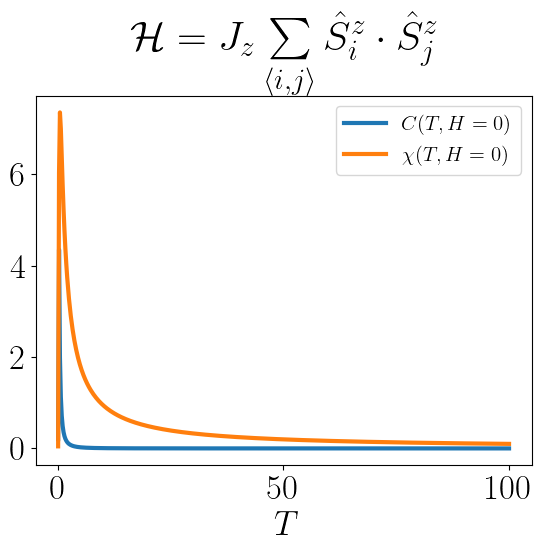

In [72]:
def take_av(arr,energy_arr,T_arr): 
    '''computes the average of arr Boltzmann distributed with energies from energy_arr for temperature grid T_Arr'''
    return np.array([np.sum(arr * np.exp(-energy_arr/T)) / np.sum(np.exp(-energy_arr/T)) for T in T_arr])
L = 10
J = 1
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
hamils = [create_hamil_mag_Zonly(L,J,mag,lookups) for mag in range(-L,L+1)] #set of mz hamiltonians for all mz

# four arrays to store all E, E^2, M, M^2
all_energies = []
all_energies_squared = []
all_mags = []
all_mags_squared = []

# to compute those arrays, we first loop over all magnetizations and then individually diagonalize
for i, mag in enumerate(range(-L,L+1)):
    lenn = len(lookups[mag])
    all_mags += [mag] * lenn #store constant mag repeated len times as the magnetization is same inside a sector
    all_mags_squared += [mag ** 2] * lenn  # same for square
    h_mag = hamils[i]
    eigenvalues ,_ = np.linalg.eigh(h_mag) 
    for eval in eigenvalues:
        all_energies.append(eval)  #store eigenvals from diagonalization
        all_energies_squared.append(eval ** 2)  #same from square

#make numpy all
all_energies = np.array(all_energies)
all_energies_squared = np.array(all_energies_squared)
all_mags = np.array(all_mags)
all_mags_squared = np.array(all_mags_squared)


T_arr = np.linspace(0.1,100.0,500) #for evaluating \chi and C

avE = take_av(all_energies,all_energies,T_arr)
avEsq = take_av(all_energies_squared,all_energies,T_arr)
avM = take_av(all_mags,all_energies,T_arr)
avMsq = take_av(all_mags_squared,all_energies,T_arr)

C_arr = (avEsq - avE ** 2) / T_arr ** 2
Chi_arr = (avMsq - avM ** 2) / T_arr 
plt.title(r'$\mathcal{H}=  J_z \sum\limits_{\langle i,j \rangle} \hat{S}^z_{i}\cdot\hat{S}^z_{j}$')
plt.plot(T_arr,C_arr,label=r'$C(T,H=0)$',linewidth=3)
plt.plot(T_arr,Chi_arr,label=r'$\chi(T,H=0)$',linewidth=3)
plt.xlabel('$T$')
plt.legend(fontsize=15,loc='upper right')

the end.